In [64]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

import sys
REPO_ROOT = r"..\.."
sys.path.append(REPO_ROOT)
from nebula.neurlux.model import NeurLuxModel
from nebula.attention import TransformerEncoderWithChunking
from nebula.models import Cnn1DLinear
from collections import defaultdict

XLIM = [-0.001, 0.006]
YLIM = [0.3, 1]

def get_roc_curve_from_folder(inFolder, model, name=None, fileIdx=0):
    # loading model
    objectFolder = os.path.join(inFolder, "training_files")
    modelFiles = [os.path.join(objectFolder, x) for x in os.listdir(objectFolder) if x.endswith(".torch")]
    modelDict = torch.load(modelFiles[fileIdx])
    model.load_state_dict(modelDict)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    # loading data
    timestamp = modelFiles[fileIdx].split("\\")[-1].split("-")[0]
    dataset_file = os.path.join(inFolder, f"dataset_splits_{timestamp}.npz")
    data_npz = np.load(dataset_file)
    
    X_test = data_npz["X_test"]
    y_test = data_npz["y_test"]
    X_test = torch.from_numpy(X_test).long().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)

    # getting predictions
    testLoader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_test, y_test),
        batch_size=64,
        shuffle=True)

    with torch.no_grad():
        y_pred = []
        y_true = []
        if name:
            print(f"Evaluating {name}...")
        else:
            print("Evaluating model...")
        for X, y in tqdm(testLoader):
            y_hat = model(X)
            y_pred.append(y_hat.cpu().numpy())
            y_true.append(y.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)

    # calculating ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

def plot_roc_curves(fpr, tpr, roc_auc, model_name, axs):
    # plotting ROC curve
    axs[0].plot(fpr, tpr, lw=2, label=f"{model_name} ROC curve (area = {roc_auc:.4f})")
    axs[0].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].grid()

    # plot zoomed in ROC curve x-axis from 0 to 0.2
    axs[1].plot(fpr, tpr, lw=2, label=f"{model_name} ROC curve (area = {roc_auc:.4f})")
    axs[1].plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    axs[1].set_xlim([0.0, 0.15])
    axs[1].set_ylim([0.85, 1.0])
    axs[1].grid()

    return axs

def plot_roc_curve(fpr, tpr, roc_auc, model_name, ax, xlim=[0, 0.15], ylim=[0.85, 1.0]):
    # plot zoomed in ROC curve
    ax.plot(fpr, tpr, lw=2, label=f"{model_name} ROC curve (area = {roc_auc:.4f})")
    #ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    return ax

In [2]:
fprs, tprs, roc_aucs = defaultdict(dict), defaultdict(dict), defaultdict(dict)

for foldIdx in [0,1,2]:
    print("Evaluation of CV fold files with idx: " + str(foldIdx))
    # NEURLUX
    inFolder = r"vocab10k_len512_ep6\neurlux_maxLens_512_6_epochs_1676307040"
    modelArch = {
            "embedding_dim": 256,
            "vocab_size": 10000,
            "max_len": 512
        }
    model = NeurLuxModel(**modelArch)
    name = model.__name__
    fprs[name][foldIdx], tprs[name][foldIdx], roc_aucs[name][foldIdx] = get_roc_curve_from_folder(inFolder, model, name=name, fileIdx=foldIdx)

    # NEURLUX BPE
    inFolder = r"vocab10k_len512_ep6\neurlux_BPE_maxLens_512_6_epochs_1676315012"
    modelArch = {
            "embedding_dim": 256,
            "vocab_size": 10003,
            "max_len": 512
        }
    model = NeurLuxModel(**modelArch)
    name = model.__name__ + " BPE"
    fprs[name][foldIdx], tprs[name][foldIdx], roc_aucs[name][foldIdx] = get_roc_curve_from_folder(inFolder, model, name=name, fileIdx=foldIdx)

    # TRANSFORMER
    inFolder = r"vocab10k_len512_ep6\Transformer_wChunks_maxLen_512_6_epochs_1676317336"
    modelArch = {
        "vocabSize": 10003,  # size of vocabulary
        "maxLen": 512,  # maximum length of the input sequence
        "chunk_size": 64,
        "dModel": 64,  # embedding & transformer dimension
        "nHeads": 8,  # number of heads in nn.MultiheadAttention
        "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
        "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
        "numClasses": 1, # binary classification
        "hiddenNeurons": [64],
        "layerNorm": False,
        "dropout": 0.2
    }
    model = TransformerEncoderWithChunking(**modelArch)
    name = "Transformer"
    fprs[name][foldIdx], tprs[name][foldIdx], roc_aucs[name][foldIdx] = get_roc_curve_from_folder(inFolder, model, name=name, fileIdx=foldIdx)


    # CNN
    inFolder = r"vocab10k_len512_ep6\Cnn1DLinear_maxLen_512_6_epochs_1676355847"
    modelArch = {
        "vocabSize": 10003,
        "maxLen": 512,
        "embeddingDim": 64,
        "hiddenNeurons": [512, 256, 128],
        "batchNormConv": False,
        "batchNormFFNN": False,
        "filterSizes": [2, 3, 4, 5],
        "dropout": 0.2
    }
    model = Cnn1DLinear(**modelArch)
    name = model.__name__
    fprs[name][foldIdx], tprs[name][foldIdx], roc_aucs[name][foldIdx] = get_roc_curve_from_folder(inFolder, model, name=name, fileIdx=foldIdx)

Evaluation of file with idx: 0
Evaluating NeurLux...


100%|██████████| 397/397 [00:06<00:00, 60.42it/s]


Evaluating NeurLux BPE...


100%|██████████| 397/397 [00:04<00:00, 93.47it/s]


Evaluating Transformer...


100%|██████████| 397/397 [00:20<00:00, 19.78it/s]


Evaluating Cnn1DLinear...


100%|██████████| 397/397 [00:04<00:00, 86.69it/s]


Evaluation of file with idx: 1
Evaluating NeurLux...


100%|██████████| 397/397 [00:04<00:00, 90.76it/s]


Evaluating NeurLux BPE...


100%|██████████| 397/397 [00:04<00:00, 91.28it/s]


Evaluating Transformer...


100%|██████████| 397/397 [00:22<00:00, 17.97it/s]


Evaluating Cnn1DLinear...


100%|██████████| 397/397 [00:03<00:00, 131.86it/s]


Evaluation of file with idx: 2
Evaluating NeurLux...


100%|██████████| 397/397 [00:03<00:00, 127.88it/s]


Evaluating NeurLux BPE...


100%|██████████| 397/397 [00:03<00:00, 130.94it/s]


Evaluating Transformer...


100%|██████████| 397/397 [00:08<00:00, 45.46it/s]


Evaluating Cnn1DLinear...


100%|██████████| 397/397 [00:03<00:00, 119.72it/s]


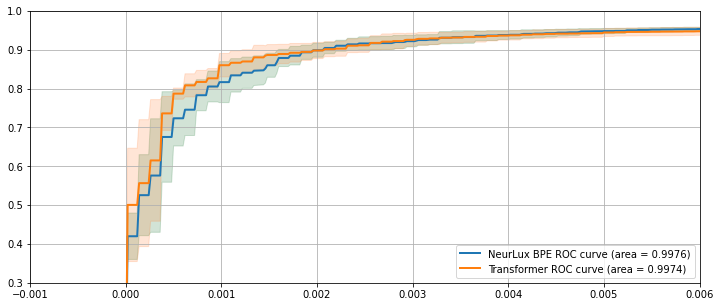

In [68]:
SKIP_MODELS = ["Cnn1DLinear", "NeurLux"]
base_fpr = np.linspace(0, 1, 50001)
trps_same = defaultdict(dict)
for key in tprs.keys():
    for idx in range(3):
        trps_same[key][idx] = np.interp(base_fpr, fprs[key][idx], tprs[key][idx])
        trps_same[key][idx][0] = 0.0

fig, ax = plt.subplots(1,1, figsize=(12,5))
for key in trps_same.keys():
    if key in SKIP_MODELS:
        continue
    # plot mean of TPRS
    mean_tpr = np.mean(list(trps_same[key].values()), axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)
    ax.plot(base_fpr, mean_tpr, lw=2, label=f"{key} ROC curve (area = {mean_auc:.4f})")
    # get color from last plot
    color = ax.lines[-1].get_color()
    # plot std of TPRS
    std_tpr = np.std(list(trps_same[key].values()), axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = mean_tpr - std_tpr
    # make color transparent -- e.g. 1f77b4 -> 1f77b433
    color = color[:-2] + "33"
    ax.fill_between(base_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)

    # plot each of TPRs for each fold
    # for idx in range(3):
    #     ax.plot(fprs[key][idx], tprs[key][idx], lw=1, alpha=0.3, color=color)

    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)


ax.legend(loc="lower right")
ax.grid()